In [1]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [1]:
import sys
sys.path.append('../')
import os
os.chdir('../')
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline

In [2]:
# import Bidrec Autoregress
from bidirec_autoregress import dataset_TM_train
import bidirec_autoregress.eval_trans as eval_trans
import bidirec_autoregress.t2m_trans as trans
from bidirec_autoregress.util import get_bidirec_input

In [3]:
import os 
import torch
import numpy as np

from torch.utils.tensorboard import SummaryWriter
from os.path import join as pjoin
from torch.distributions import Categorical
import json
import clip

import options.option_transformer as option_trans
import models.vqvae as vqvae
import utils.utils_model as utils_model
# import utils.eval_trans as eval_trans
# from dataset import dataset_TM_train
from dataset import dataset_TM_eval
from dataset import dataset_tokenize
# import models.t2m_trans as trans
from options.get_eval_option import get_opt
from models.evaluator_wrapper import EvaluatorModelWrapper
import warnings
warnings.filterwarnings('ignore')
from exit.utils import get_model, visualize_2motions, generate_src_mask

import os
# os.environ["CUDA_LAUNCH_BLOCKING"]="1"
# os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [4]:
class Temp:
    def __init__(self):
        print('mock:: opt')
args = Temp()
args.dataname = args.dataset_name = 't2m'
args.down_t = 2

train_loader_token = dataset_tokenize.DATALoader(args.dataname, 1, unit_length=2**args.down_t)

from utils.word_vectorizer import WordVectorizer
w_vectorizer = WordVectorizer('./glove', 'our_vab')
val_loader = dataset_TM_eval.DATALoader(args.dataname, False, 32, w_vectorizer)

dataset_opt_path = 'checkpoints/kit/Comp_v6_KLD005/opt.txt' if args.dataname == 'kit' else 'checkpoints/t2m/Comp_v6_KLD005/opt.txt'

wrapper_opt = get_opt(dataset_opt_path, torch.device('cuda'))
eval_wrapper = EvaluatorModelWrapper(wrapper_opt)

mock:: opt


100%|██████████| 1460/1460 [00:00<00:00, 2977.48it/s]


Pointer Pointing at 0
Reading checkpoints/t2m/Comp_v6_KLD005/opt.txt
Loading Evaluation Model Wrapper (Epoch 28) Completed!!


In [5]:
##### ---- Network ---- #####
clip_model, clip_preprocess = clip.load("ViT-B/32", device=torch.device('cuda'), jit=False)  # Must set jit=False for training
clip.model.convert_weights(clip_model)  # Actually this line is unnecessary since clip by default already on float16
clip_model.eval()
for p in clip_model.parameters():
    p.requires_grad = False

class TextCLIP(torch.nn.Module):
    def __init__(self, model) :
        super(TextCLIP, self).__init__()
        self.model = model
        
    def forward(self,text):
        return self.model.encode_text(text)
clip_model = TextCLIP(clip_model)

In [6]:
args.nb_code = 512 # 8192 # 
args.code_dim = 512 # 32 # 
args.output_emb_width = 512
args.down_t = 2
args.stride_t = 2
args.width = 512
args.depth = 3
args.dilation_growth_rate = 3
args.vq_act = 'relu'
args.vq_norm = None
args.quantizer = 'ema_reset'
args.mu = 0.99
args.embed_dim_gpt = 1024
args.clip_dim = 512
args.block_size = 49
args.num_layers = 9
args.n_head_gpt = 16
args.drop_out_rate = 0.1
args.ff_rate = 4

args.vq_name = 'VQVAE_official_last'
args.exp_name = 'TEMP'
args.out_dir = 'output_GPT_Final'
args.out_dir = os.path.join(args.out_dir, f'{args.exp_name}')
args.vq_dir= f'output/{args.vq_name}'
codebook_dir = f'{args.vq_dir}/codebook/'
os.makedirs(args.out_dir, exist_ok = True)
os.makedirs(args.vq_dir, exist_ok = True)
os.makedirs(codebook_dir, exist_ok = True)

net = vqvae.HumanVQVAE(args, ## use args to define different parameters in different quantizers
                       args.nb_code,
                       args.code_dim,
                       args.output_emb_width,
                       args.down_t,
                       args.stride_t,
                       args.width,
                       args.depth,
                       args.dilation_growth_rate)
trans_encoder = trans.Text2Motion_Transformer(num_vq=args.nb_code, 
                                            embed_dim=args.embed_dim_gpt, 
                                            clip_dim=args.clip_dim, 
                                            block_size=args.block_size, 
                                            num_layers=args.num_layers, 
                                            n_head=args.n_head_gpt, 
                                            drop_out_rate=args.drop_out_rate, 
                                            fc_rate=args.ff_rate)
args.resume_pth = '/home/epinyoan/git/MaskText2Motion/T2M-GPT-Batch/output/VQVAE_official_last/net_last.pth'
ckpt = torch.load(args.resume_pth, map_location='cpu')
net.load_state_dict(ckpt['net'], strict=True)
# net = torch.nn.DataParallel(net)

args.resume_trans = '/home/epinyoan/git/MaskText2Motion/T2M-GPT-Batch/output/2023-05-03-16-01-13_HML3D_3_BidirAutoreg_big/net_last.pth'
ckpt = torch.load(args.resume_trans, map_location='cpu')
trans_encoder.load_state_dict(ckpt['trans'], strict=True)
trans_encoder = torch.nn.DataParallel(trans_encoder)
net.eval()
net.cuda()
trans_encoder.train()
trans_encoder.cuda()
''

''

### VQVAE encoder index precomputed

In [ ]:
for batch in train_loader_token:
    pose, name = batch
    bs, seq = pose.shape[0], pose.shape[1]

    pose = pose.cuda().float() # bs, nb_joints, joints_dim, seq_len
    target = net(pose, type='encode')
    target = target.cpu().numpy()
    np.save(pjoin(codebook_dir, name[0] +'.npy'), target)

In [7]:
######## count used indices
# all_indices = None
# for batch in train_loader_token:
#     pose, name = batch
#     pose = pose.cuda().float()
    
#     target = net(pose, type='encode').squeeze()
#     if all_indices is None:
#         all_indices = target
#     else:
#         all_indices = torch.cat([all_indices, target])
# c = torch.bincount(all_indices.view(-1))
# (c==0).sum()

### Train

In [7]:
args.batch_size = 2
num_workers = 8
train_loader = dataset_TM_train.DATALoader(args.dataname, args.batch_size, args.nb_code, codebook_dir, unit_length=2**args.down_t, num_workers=num_workers)
train_loader_iter = dataset_TM_train.cycle(train_loader)

100%|██████████| 23384/23384 [00:05<00:00, 4138.56it/s]


### Bidirectional AutoRegressive

In [8]:
# Rearange
# 1. taget
# 2. input (called in 1. training & 2. sampling)
# 3. mask

In [10]:
target = torch.tensor([[100, 101, 102, 103, 104, 512, 513, 513],
                        [100, 101, 102, 103, 104, 105, 512,513],
                        [100, 101, 102, 103, 104, 105, 106, 512],
                        [512, 512, 512, 512, 512, 512, 512, 512]]).cuda()
m_tokens_len = torch.tensor([5, 6, 7, 2]).cuda()
# get_bidirec_input(target, m_tokens_len)

tensor([[ -1, 100, 101, 104,  -2, 513, 513, 513],
        [ -1, 100, 101, 104, 105,  -2, 513, 513],
        [ -1, 100, 101, 102, 105, 106,  -2, 512],
        [ -1,  -2, 512, 512, 512, 512, 512, 512]], device='cuda:0')

In [15]:
args.pkeep = .5
batch = next(train_loader_iter)
clip_text, m_tokens, m_tokens_len = batch
m_tokens, m_tokens_len = m_tokens.cuda(), m_tokens_len.cuda()
bs = m_tokens.shape[0]
target = m_tokens    # (bs, 26)
target = target.cuda()

text = clip.tokenize(clip_text, truncate=True).cuda()
    
feat_clip_text = clip_model(text).float()

input_index = target #[:,:-1]

if args.pkeep == -1:
    proba = np.random.rand(1)[0]
    mask = torch.bernoulli(proba * torch.ones(input_index.shape,
                                                        device=input_index.device))
else:
    mask = torch.bernoulli(args.pkeep * torch.ones(input_index.shape,
                                                        device=input_index.device))
# random only motion token (not pad token). To prevent pad token got mixed up.
seq_mask_no_end = generate_src_mask(target.shape[1], m_tokens_len)
mask = torch.logical_or(mask, ~seq_mask_no_end).int()
r_indices = torch.randint_like(input_index, args.nb_code)
a_indices = mask*input_index+(1-mask)*r_indices
a_indices = get_bidirec_input(a_indices, m_tokens_len)

cls_pred = trans_encoder(a_indices, feat_clip_text, m_tokens_len, target.shape[-1])

###### Compute Batch Xent ######
loss_ce = torch.nn.CrossEntropyLoss(reduction='none')
cb_idx_mask = generate_src_mask(target.shape[1], m_tokens_len)
cls_pred_all_masked = torch.masked_select(cls_pred, cb_idx_mask.unsqueeze(-1)).view(-1, cls_pred.shape[-1])
target_all_masked = torch.masked_select(target, cb_idx_mask)

denom = torch.ones(*target.shape).cuda() * bs * (m_tokens_len).unsqueeze(-1)
denom = torch.masked_select(denom, cb_idx_mask)

loss_cls = loss_ce(cls_pred_all_masked, target_all_masked) / denom
loss_cls = loss_cls.sum()
loss_cls


tensor(7.1443, device='cuda:0', grad_fn=<SumBackward0>)

In [16]:
trans_encoder(a_indices, feat_clip_text, m_tokens_len, target.shape[-1])
target.shape

torch.Size([2, 49])

#### Mask

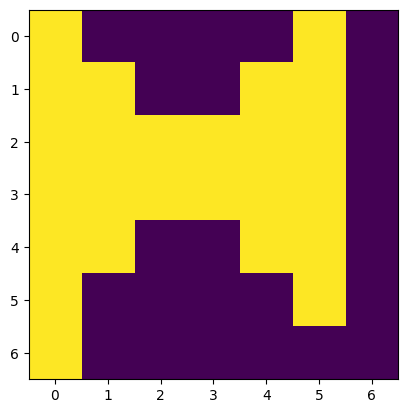

In [17]:
target = torch.tensor([[10, 11, 12, 13, 14, 512, 512],
                        [10, 11, 12, 13, 14, 15, 512],
                        [10, 11, 12, 13, 14, 15, 16]]).cuda()
m_tokens_len = torch.tensor([5,6,7]).cuda()
n_head = 2

# all_mask = trans.get_attn_mask(m_tokens_len, target.shape[1], n_head)
temp = trans.get_attn_mask(m_tokens_len, target.shape[1], n_head)
plt.imshow(temp[1, 0].cpu().numpy())

#### Sample

In [18]:
target = torch.tensor([[100, 101, 102, 103, 104, 512, 513, 513],
                        [100, 101, 102, 103, 104, 105, 512,513],
                        [100, 101, 102, 103, 104, 105, 106, 512],
                        [100, 101, 102, 103, 104, 105, 106, 512]]).cuda()
m_tokens_len = torch.tensor([5, 6, 7, 7]).cuda()
text = clip.tokenize(['a', 'b', 'c', 'd'], truncate=True).cuda()
feat_clip_text = clip_model(text).float()

index_motion = trans_encoder(feat_clip_text, m_tokens_len, target.shape[-1], False, type="sample")
index_motion.shape

torch.Size([4, 8])

In [19]:
max_steps = torch.floor(m_tokens_len.max()/2)
max_steps.item()

3.0

### Eval

In [20]:
val_loader = dataset_TM_eval.DATALoader(args.dataname, False, 32, w_vectorizer)

100%|██████████| 1460/1460 [00:00<00:00, 2949.09it/s]

Pointer Pointing at 0


In [21]:
class LoggerWriterMock:
    def __init__(self):
        self.info
    def info(self, *args):
        print(*args)
    def add_scalar(self, *args):
        print(*args)
    def add_video(self, *args):
        print(*args)
logger = LoggerWriterMock()
logger.info('test')
writer = LoggerWriterMock()
writer.add_scalar('./Test/FID', 'fid', 'nb_iter')

test
./Test/FID fid nb_iter


In [22]:
########## Mask Motion in Eval ####################
index_motion = torch.randint(0, 513, (8, 51)).cuda()
blank_id = 512 # get_model(trans_encoder).num_vq
index_motion[1, 5] = blank_id
index_motion[1, 7] = blank_id
index_motion[4, 9] = blank_id
index_motion[0, 0] = blank_id
index_motion[-1, 1] = blank_id

# [INFO] 1. this get the last index of blank_id
# pred_length = (index_motion == blank_id).int().argmax(1).float()
# [INFO] 2. this get the first index of blank_id
pred_length = (index_motion >= blank_id).int()
pred_length = torch.topk(pred_length, k=1, dim=1).indices.squeeze().float()
pred_length[pred_length==0] = index_motion.shape[1]

index_motion.shape, pred_length 

(torch.Size([8, 51]),
 tensor([51.,  5., 51., 51.,  9., 42., 51.,  1.], device='cuda:0'))

In [ ]:
pred_pose_eval, pose, m_length, clip_text, best_fid, best_iter, best_div, best_top1, best_top2, best_top3, best_matching, multimodality, writer, logger = \
    eval_trans.evaluation_transformer(args.out_dir, 
        val_loader, 
        net, 
        trans_encoder, 
        logger, 
        writer, 
        0, 
        best_fid=1000, 
        best_iter=0, 
        best_div=100, 
        best_top1=0, 
        best_top2=0, 
        best_top3=0, 
        best_matching=100, 
        clip_model=clip_model, 
        eval_wrapper=eval_wrapper,
        num_repeat=11)